In [2]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from unidecode import unidecode
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)
from scipy.stats import pearsonr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_columns', 100)

### 1. Read SCM & ERA data

In [3]:
# Read ERA data
era_final = pd.read_csv("files/ERA/processed/era_final_features.csv")
era_raw = pd.read_csv("files/ERA/processed/era_tmean_rain_all_departments.csv").assign(model="ERA", init_month=12)

# Read and preprocess hindcast data from different climate models
c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
apcc = pd.read_csv("clik-apcc/data/apcc_hindcasts.csv")
scm = pd.concat([nmme, c3s, apcc], ignore_index=True).drop_duplicates()
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(8, 11) & (scm["model"] != "HMC"))].reset_index(drop=True)

# Store variables used throughout the notebook
climate_models = scm["model"].unique().tolist()
climate_models.sort()
crop_seasons = scm["year"].unique().tolist()
relevant_municipalities = list(set([c.split("_")[1] for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))
weather_columns_final = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]

# Extract raw weather columns based on basis expansion needed for final features
weather_columns_raw = []
new_dict = dict(zip(["tmean", "rain"], [dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("tmean" in c)]),
                                        dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("rain" in c)])]))
for var in new_dict:
    for loc in new_dict[var]:
        new_dict[var][loc] = list(set([int(c.split("_")[-1]) for c in weather_columns_final if (var in c) and (loc in c)]))
        for month in new_dict[var][loc]:
            weather_columns_raw.append("{}_{}_{}".format(var, loc, month))
            
era_raw = era_raw.loc[:, ["year", "model", "init_month"] + weather_columns_raw]

# Display a random sample from the processed hindcast data
scm.sample(2)


,model,year,init_month,forecasted_month,rain,tmean,lat,lon
187104,CMCC,1995,10,10,0.001477,13.863611,-39.0,-60.0
9012,GFDL,2010,9,9,0.001506,7.403146,-43.0,-57.0


### 2. Filter SCM locations

**2.1 Obtain polygon shapes of relevant municipalities**

To forecast wheat yield in Argentina, we use weather data from two locations - Buenos Aires Coronel Dorrego and Buenos Aires Hipolito Yrigoyen. SCM data is often provided in e.g. 1° x 1° or 2.5° x 2.5° grid cells. For each location, we need to find the *k* grid cells that are closest. 

In [4]:
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_municipalities), ["name", "geometry"]].reset_index(drop=True)
relevant_municipalities = gdf_adm2["name"].unique().tolist()
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
name_to_shape

{'buenos aires coronel suarez': <POLYGON Z ((-61.603 -36.993 0, -61.735 -37.093 0, -61.735 -37.095 0, -61.73...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**2.2 Preview SCM locations and relevant municipality locations**

<Axes: >

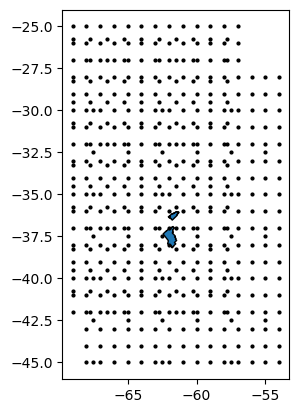

In [5]:
# Convert SCM dataframe to geodataframe to facilitate spatial filtering in the next section
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"]), crs="EPSG:4326")
base = gdf_adm2["geometry"].plot(edgecolor="black")
gpd.GeoDataFrame(scm.loc[:, ["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base, color="black", markersize=4)

**2.3 Filter SCM hindcasts**

For each relevant municipality, we select K grid cell locations from each SCM that are closest to that municipality. If a SCM has a sparse resolution, it may be that the same grid cell is used for both locations.

In [6]:
def get_nearest_neighbors(src_points, candidate_points, k_neighbors=2):
    """
    Find k nearest neighbors for all source points from a set of candidate points
    modified from: https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html    
    params:
        src_points : geopandas.DataFrame Geometries to search from.
        candidate_points : geopandas.DataFrame Geoemtries to be searched.
        k_neighbors : int, optional Number of nearest neighbors. The default is 2.
    returns:
        tuple containing lists of indices of the closest and second closest locations 
    """
    src_points = [(x,y) for x,y in zip(src_points.geometry.centroid.x , src_points.geometry.centroid.y)]
    candidates =  [(x,y) for x,y in zip(candidate_points.geometry.x , candidate_points.geometry.y)]
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')
    distances, indices = tree.query(src_points, k=k_neighbors)
    distances = distances.transpose()
    indices = indices.transpose()
    closest = indices[0]
    second_closest = indices[1] 

    return (closest, second_closest)

In [7]:
filtered_scm = []
for model in climate_models:
    coordinates_of_scm = scm.loc[scm["model"] == model, ["model", "geometry"]].drop_duplicates().reset_index(drop=True).copy()
    (ids_closest, ids_second_closest) = get_nearest_neighbors(gdf_adm2, coordinates_of_scm, 2)
    filtered_coordinates = coordinates_of_scm.iloc[list(ids_closest) + list(ids_second_closest)].reset_index(drop=True)
    filtered_coordinates = filtered_coordinates.assign(name=pd.Series(2 * relevant_municipalities))
    filtered_scm.append(scm.loc[scm["model"] == model].merge(filtered_coordinates[["name", "geometry"]], on="geometry", how="right"))
    
filtered_scm = pd.concat(filtered_scm, ignore_index=True)

<Axes: >

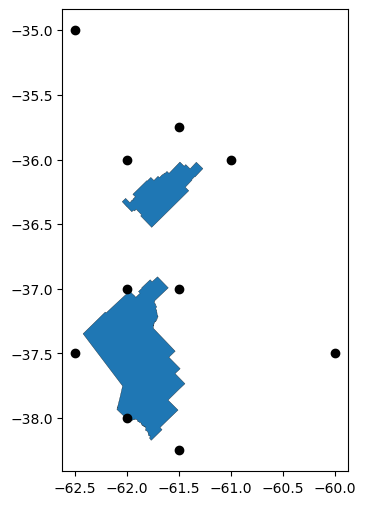

In [8]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gpd.GeoDataFrame(filtered_scm[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

### 3. Bring SCM hindcasts into feature structure

In [9]:
li =[]
for m in relevant_municipalities:
    df = filtered_scm.loc[filtered_scm["name"] == m].pivot_table(
        index=["model", "year", "init_month", "lat", "lon"],
        columns=["name", "forecasted_month"],
        values=["tmean", "rain"]
    ).reset_index()
    df.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in df.columns]
    df.columns = [c.strip("_") for c in df.columns]
    df = df.set_index(["model", "year", "init_month", "lat", "lon"])
    li.append(df)

scm_pivot = pd.concat(li, axis=1, join="outer").reset_index().sort_values(by=["model", "year", "init_month", "lat", "lon"]).reset_index(drop=True)
scm_pivot = scm_pivot.loc[:, ["year", "model", "init_month"] + ["lat", "lon"] + weather_columns_raw]
scm_pivot.sample(3)

,year,model,init_month,lat,lon,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
3887,1995,NASA,11,-36.0,-61.0,NaN,NaN,NaN,NaN,NaN
3871,1994,NASA,11,-36.0,-61.0,NaN,NaN,NaN,NaN,NaN
3889,1996,NASA,8,-37.0,-62.0,12.909147,21.616563,0.000848,0.001394,NaN


### 4. Adjust Bias

In [10]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in climate_models:
        adjusted_init_months = []
        for month in predicted["init_month"].unique().tolist():
            adjusted_cols = []
            for col in weather_columns_raw:
                adjusted_years = []
                for year in crop_seasons:
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month"]].copy()
                    # Perform bias-adjustment 
                    if int(col.split("_")[-1]) >= month:
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [11]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot, "basic_quantile")
scm_bias_adjusted.sample(3)

,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
634,CCSM4,2014,10,NaN,NaN,NaN,NaN,NaN
902,CMCC,2007,9,NaN,NaN,NaN,NaN,0.001478
860,CMCC,2004,11,NaN,16.29975,NaN,0.002575,NaN


### 5. Standardize and Basis Expansion

Standardization is done through the LOYO-CV scheme, separately for each model.

In [12]:
def standardize_loyo(scm_df, era_df):
    scm_df = scm_df.copy()
    era_df = era_df.copy()
    standardized_data = []
    for model in scm_df["model"].unique():
        standardized_data_init_month = []
        for month in scm_df["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = era_df.loc[(era_df["year"] != year), [c for c in era_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), [c for c in scm_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_df.loc[:, [c for c in [l for l in standardized_df.columns if ("tmean" in l) or ("rain" in l)] if (int(c.split("_")[-1]) < month)]] = np.nan
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(scm_df, era_raw_df, era_final_df, final_features):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(scm_df, era_raw_df)
    df_standardized = df_standardized.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])

    for col in final_features:
        type_of_expansion = col.split("_")[0]
        location = col.split("_")[1]
        month = col.split("_")[2]
        
        if type_of_expansion == "tmeansquared":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            df_standardized[col] = tmean.mul(tmean)
        if type_of_expansion == "rainsquared":
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain.mul(rain)
        if type_of_expansion == "tmeanrain":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain * tmean.values
    
    df_standardized = df_standardized[final_features].reset_index()
    
    # standardize expanded features again
    df_standardized = standardize_loyo(df_standardized, era_final_df)
    df_standardized = df_standardized.groupby(["model", "year", "init_month"]).mean()[final_features].reset_index()
    
    return df_standardized

In [13]:
scm_basis_expansion = apply_basis_expansion(scm_bias_adjusted, era_raw, era_final, weather_columns_final)
scm_basis_expansion.sample(3)

,model,year,init_month,tmeanrain_buenos aires coronel suarez_9,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_buenos aires coronel suarez_11,tmeansquared_buenos aires coronel suarez_11
40,BOM,2003,8,0.034536,0.024168,-0.171274,0.180786
112,CCSM4,1997,8,-0.016837,-0.081892,0.586348,0.629011
688,GFDL,1997,8,0.774458,0.366026,0.285993,0.777783


### 5. Fill past months with ERA data

In [14]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield anomaly [%],tmeanrain_buenos aires coronel suarez_9,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_buenos aires coronel suarez_11,tmeansquared_buenos aires coronel suarez_11
1319,2004,PNU,11,0.093354,0.310226,-0.285739,0.114436,-0.108672
118,1998,CCSM4,10,-0.006932,-2.602528,-0.536153,0.207167,0.081570
541,2008,ECCC,9,-0.290659,-0.268208,0.176526,-2.029679,5.122257
911,1998,KMA,11,-0.006932,-2.602528,-0.536153,0.153566,0.108007
670,2016,ECMWF,10,0.066009,0.453573,-0.437576,0.085688,0.300787


### 6. Calculate performance metrics

#### 6.1 Out-of-sample R<sup>2</sup>

In [53]:
def r2_by_feature_init_month_and_scm(init_month, climate_models, scm_df, features):
    scm = scm_df.loc[scm_df["model"] != "ERA"].reset_index().set_index(["model", "year", "init_month"]).copy()
    era = scm_df.loc[scm_df["model"] == "ERA"].reset_index().copy()
    
    model_to_col_to_r2 = dict.fromkeys(climate_models)
    loyo_mean = (era[features].sum() - era[features]) / (era.shape[0] - 1)
    
    for model in climate_models:
        forecasted_scm = scm.xs(init_month, level=2, drop_level=True).xs(model, level=0, drop_level=True)[features]
        
        ss_total = mse(era[features], loyo_mean, multioutput="raw_values")
        ss_model = mse(era[features], forecasted_scm, multioutput="raw_values")
        
        current_r2 = 1 - ( ss_model / ss_total )
        model_to_col_to_r2[model] = dict(zip(features, current_r2))

    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2).assign(init_month=init_month)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = 0
    return model_to_col_to_r2

r2_8 = r2_by_feature_init_month_and_scm(8, climate_models, scm_era, weather_columns_final)
r2_9 = r2_by_feature_init_month_and_scm(9, climate_models, scm_era, weather_columns_final)
r2_10 = r2_by_feature_init_month_and_scm(10, climate_models, scm_era, [c for c in weather_columns_final if ("_9" not in c)])
r2_11 = r2_by_feature_init_month_and_scm(11, climate_models, scm_era, [c for c in weather_columns_final if ("_11" in c)])

r2_by_init = pd.concat([r2_8, r2_9, r2_10, r2_11])

In [54]:
r2_8

,BOM,CCSM4,CMCC,CWB,DWD,ECCC,ECMWF,GFDL,JMA,KMA,METFR,NASA,NCEP,PNU,UKMO,init_month
tmeanrain_buenos aires coronel suarez_9,0.005202,0.058842,0.015001,0.075507,0.000000,0.000000,0.210496,0.000000,0.060399,0.244487,0.208419,0.000000,0.130631,0.162051,0.293065,8
rainsquared_buenos aires hipolito yrigoyen_9,0.318119,0.253870,0.493955,0.374430,0.273699,0.230821,0.400473,0.354979,0.354897,0.251943,0.299191,0.000000,0.527877,0.520077,0.185936,8
tmeanrain_buenos aires coronel suarez_11,0.297142,0.087750,0.013305,0.095668,0.000000,0.000000,0.000000,0.306626,0.210156,0.045323,0.181882,0.000000,0.000000,0.015406,0.096357,8
tmeansquared_buenos aires coronel suarez_11,0.466324,0.324672,0.304326,0.172436,0.223198,0.361769,0.554367,0.474392,0.360710,0.333752,0.311020,0.783419,0.187067,0.234532,0.245842,8


#### 6.2 Bias, MAE, correlation

In [55]:
# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
scm_models = [c for c in scm_era.model.unique().tolist() if c != "ERA"]
weather_columns = [c for c in scm_era.columns if ("_11" in c) or ("_9" in c)]

In [56]:
scm_bias = scm_era.loc[scm_era["model"].isin(scm_models)]
era_bias = scm_era.loc[scm_era["model"] == "ERA"].set_index("year")[weather_columns]

all_bias = []
for model in scm_models:
    for month in init_months:
        current_scm = scm_bias.loc[(scm_bias["model"] == model) & (scm_bias["init_month"] == month)].set_index("year")
        # MAE
        current_scm_mae = abs(current_scm[weather_columns] - era_bias)
        current_scm_mae.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        # Pearson's r
        X = (current_scm[weather_columns] - current_scm[weather_columns].mean(axis=0)) / current_scm[weather_columns].std(axis=0)
        Y = (era_bias - era_bias.mean(axis=0)) / era_bias.std(axis=0)
        pearson_r = np.dot(X.T, Y) / X.shape[0]
        pearson_r = pearson_r.diagonal()
        current_scm_r = pd.DataFrame(data={"model":[model], "init_month":[month], "metric":["pearson"]})
        current_scm_r[weather_columns] = pearson_r
        # Bias
        current_scm_bias = current_scm[weather_columns] - era_bias
        current_scm_bias.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        
        current_scm_info = current_scm[['model', 'init_month', 'yield anomaly [%]']]
        
        current_scm_mae = pd.concat([current_scm_info, current_scm_mae], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False).assign(metric="MAE")
        current_scm_bias = pd.concat([current_scm_info, current_scm_bias], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False).assign(metric="Bias")
        current_scm_metrics = pd.concat([current_scm_mae, current_scm_bias], axis=0)
        current_scm = pd.concat([current_scm_metrics, current_scm_r], axis=0)
        #current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1)[['model', 'init_month']+weather_columns]
        all_bias.append(current_scm)
all_bias = pd.concat(all_bias)

In [57]:
all_bias = all_bias.set_index(["model", "init_month", "metric"]).stack().reset_index()
all_bias.columns = ["model", "init_month", "metric", "feature", "value"]

In [58]:
metric_r = all_bias.groupby(["model", "init_month", "metric"])["value"].mean().reset_index()
metric_r = metric_r.loc[metric_r["metric"] == "pearson", ["model", "init_month", "value"]].pivot(index="model", columns="init_month", values="value")

metric_mae = all_bias.groupby(["model", "init_month", "metric"])["value"].mean().reset_index()
metric_mae = metric_mae.loc[metric_mae["metric"] == "MAE", ["model", "init_month", "value"]].pivot(index="model", columns="init_month", values="value")

metric_bias = all_bias.groupby(["model", "init_month", "metric"])["value"].mean().reset_index()
metric_bias = metric_bias.loc[metric_bias["metric"] == "Bias", ["model", "init_month", "value"]].pivot(index="model", columns="init_month", values="value")

metric_r2 = r2_by_init.groupby("init_month").mean().transpose()

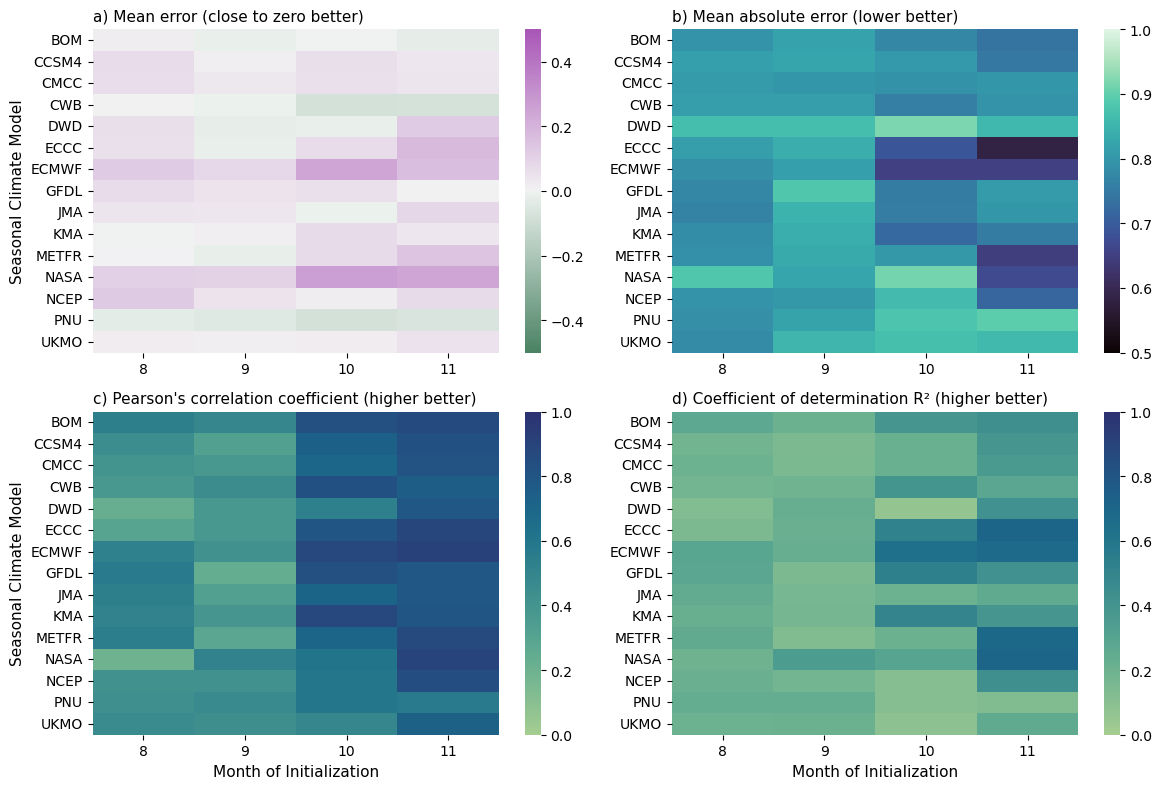

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.ravel()

sns.heatmap(metric_bias, vmin=-0.5, vmax=0.5, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=axs[0])
axs[0].set_ylabel("Seasonal Climate Model", size=11);
axs[0].set_xlabel("");
axs[0].set_title("a) Mean error (close to zero better)", loc="left", size=11);

sns.heatmap(metric_mae, vmin=0.5, vmax=1, cmap="mako", ax=axs[1])
axs[1].set_ylabel("");
axs[1].set_xlabel("");
axs[1].set_title("b) Mean absolute error (lower better)", loc="left", size=11);

sns.heatmap(metric_r, vmin=0, vmax=1, cmap="crest", ax=axs[2])
axs[2].set_ylabel("Seasonal Climate Model", size=11);
axs[2].set_xlabel("Month of Initialization", size=11);
axs[2].set_title("c) Pearson's correlation coefficient (higher better)", loc="left", size=11);

sns.heatmap(metric_r2, vmin=0, vmax=1, cmap="crest", ax=axs[3])
axs[3].set_ylabel("");
axs[3].set_xlabel("Month of Initialization", size=11);
axs[3].set_title("d) Coefficient of determination R\u00b2 (higher better)", loc="left", size=11);

plt.tight_layout()

plt.savefig("files/figures/figure3.png")

In [76]:
metric_mae.mean(axis=1).sort_values()

model
ECMWF    0.726392
ECCC     0.730107
METFR    0.767576
KMA      0.774475
BOM      0.781556
JMA      0.791950
CWB      0.793482
NCEP     0.793728
CCSM4    0.798366
CMCC     0.799031
GFDL     0.805093
NASA     0.823211
UKMO     0.840006
PNU      0.845167
DWD      0.878763
dtype: float64

## EXPORT

In [62]:
scm_era.to_csv("files/ERA/processed/era_scm_final_features.csv", index=False)